### Comparison of skewed distribution estimation.

We are trying to estimate $\alpha$-quantile of a distribution:
$$q_\alpha(Y) = \inf \{y \in \mathbb{R}| F_Y (y) \geq \alpha\}$$

There are two estimation methods:
1. Using empirical quantile function. 
$$\hat{q}_\alpha(Y_n) = \inf \{y \in \mathbb{R}| F_{Y_n} (y) \geq \alpha\} = Y_n(i)$$
where $i$ is chosen such that
$$\frac{i-1}{n} < p \leq \frac{i}{n}$$
and $X_n(1), ...., X_n(n)$ are the order statistics of the sample,
$$X_n(1)\leq ...\leq X_n(n)$$ 
where $(X_n(1), ...., X_n(n))$ is a permutation of the sample $X_1, ..., X_n$

2. Fit normal distribution on given samples and estimate using mean and standard deviation.
$$\hat{N}(Y_n, m) = \mu(Y_n) + m \sigma(Y_n)$$
when m = 1, we know $F(\mu + m \sigma) - F(\mu - m \sigma)$ = 0.68. If we assume the estimated distribution is normal distribution $F(\mu) = 0.5$. Thus $F(\mu + \sigma)$ = 0.5 + 0.68/2 = 0.84

Our suspection is that the empirical quantile function has a better estimation for skewed distribution (that is, actually, a unfair comparision, since for skewed distribution $\mu$ is no longer 50% quantile), we'd like to show that 
$$\mathbb{E}[|\hat{N}(Y_n, m) - q_\alpha(Y)| - |\hat{q}_\alpha(Y_n) - q_\alpha(Y)|] \geq 1 - e^z $$
e.g. where $m = 1$ and $\alpha = 0.84$

In [1]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
from collections import defaultdict

In [2]:
def gen_from_normal(loc, scale):
    '''
    generate one data point from normal distribution
    '''
    return np.random.normal(loc,scale)

def gen_from_skewed(loc, scale, skew):
    '''
    generate one data point from skewed normal distribution
    '''
    sigma = skew / np.sqrt(1.0 + skew**2) 

    afRN = np.random.randn(2)
    u0 = afRN[0]
    v = afRN[1]
    u1 = sigma*u0 + np.sqrt(1.0 -sigma**2) * v 

    if u0 >= 0:
        return u1* scale + loc
    return (-u1)*scale + loc

def estimate_quatile(data, alpha):
    '''
    return the alpha-quantile for given data samples
    '''
    data = np.sort(data)
    idx = int(len(data) * alpha)
    return data[idx]

def estimate_with_norass(data, m):
    '''
    return mu + m * std with the assumption of normal distribution
    '''
    mu, std = norm.fit(data)
    return mu + m * std

def compare(emp_quantile, emp_norm, true_quantile):
    '''
    return the expection of the difference
    '''
    return np.mean(abs(emp_norm - true_quantile) - abs(emp_quantile - true_quantile))

In [3]:
def run_exper_for_skew_data(num_rounds, test_comb):
    '''
    run experiment for skewed data, return the expection of the difference 
    test_comb is the list of alpha (quantile level), m (number of std for normal distribution), 
    true quantile level (since hard to get from compution, we get it from large number of sampling)
    '''
    alpha, m, true_quantile = test_comb
    sample_list = []
    quantile_estimation_list = []
    norass_estimation_list = []
    expected_diff_list = []
    for i in range(num_rounds):
        sample = gen_from_skewed(loc=0,scale=1,skew=4)
        sample_list.append(sample)
        quantile_estimation_list.append(estimate_quatile(sample_list, alpha))
        norass_estimation_list.append(estimate_with_norass(sample_list, m))
        expected_diff = compare(np.asarray(quantile_estimation_list), 
                               np.asarray(norass_estimation_list),
                               true_quantile)
        expected_diff_list.append(expected_diff)
    return expected_diff_list

In [4]:
def run_exper_for_normal_data(num_rounds, test_comb):
    '''
    run experiment for skewed data, return the expection of the difference 
    test_comb is the list of alpha (quantile level), m (number of std for normal distribution), 
    true quantile level (since hard to get from compution, we get it from large number of sampling)
    '''
    alpha, m, true_quantile = test_comb
    sample_list = []
    quantile_estimation_list = []
    norass_estimation_list = []
    expected_diff_list = []
    for i in range(num_rounds):
        sample = gen_from_normal(loc=0,scale=1)
        sample_list.append(sample)
        quantile_estimation_list.append(estimate_quatile(sample_list, alpha))
        norass_estimation_list.append(estimate_with_norass(sample_list, m))
        expected_diff = compare(np.asarray(quantile_estimation_list), 
                               np.asarray(norass_estimation_list),
                               true_quantile)
        expected_diff_list.append(expected_diff)
    return expected_diff_list

### Experiment for skewed distribution

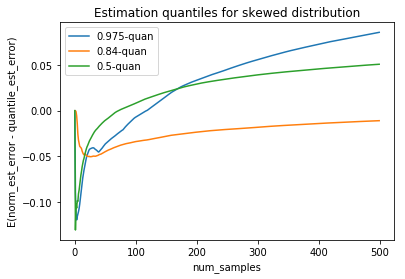

In [5]:
test_combs = [[0.975, 1.96, 2.2413], [0.84, 1, 1.4048], [0.5, 0, 0.6741]]
test_names = ['0.975-quan', '0.84-quan', '0.5-quan']
num_trails = 100
diff = defaultdict(list)
for i, test in enumerate(test_combs):
    for j in range(num_trails):
        diff[test_names[i]].append(run_exper_for_skew_data(500, test))
    mean = np.mean(np.asarray(diff[test_names[i]]), axis = 0).tolist()
    plt.plot(range(len(mean)),mean, label = test_names[i])
plt.legend()
plt.xlabel('num_samples')
plt.ylabel('E(norm_est_error - quantile_est_error)')
plt.title('Estimation quantiles for skewed distribution')

For skewed distribution, the normal distribution assumption is obviously not sure, thus we expect the empirical quantile estimation can have a smaller estimation error, that is, we expect the y-axis is bigger than 0. 

It reasonable for first several samples, quantile estimation has bad estimation since it can depends on data observed and quantile estimation makes no assumption the what the data will look like. 

But for $\alpha = 0.84$, the y-axis is always smaller than 0, which means normal estimation has a better estimation for all the time. That is a little bit surprising. 

### Experiment for normal distribution

In [ ]:
test_combs = [[0.975, 1.96, 1.9590], [0.84, 1, 0.9936], [0.5, 0, 0]]
test_names = ['0.975-quan', '0.84-quan', '0.5-quan']
num_trails = 50
diff = defaultdict(list)
for i, test in enumerate(test_combs):
    for j in range(num_trails):
        diff[test_names[i]].append(run_exper_for_normal_data(500, test))
    mean = np.mean(np.asarray(diff[test_names[i]]), axis = 0).tolist()
    plt.plot(range(len(mean)),mean, label = test_names[i])
plt.legend()
plt.xlabel('num_samples')
plt.ylabel('E(norm_est_error - quantile_est_error)')
plt.title('Estimation quantiles for normal distribution')

For normal distribution, we suspect the normal distribution assumption useful and the empirical quantile estimation can have a bigger estimation error, that is, we expect the y-axis is smaller than 0. 

The result is accord with our suspection.